In [1]:
#-------- Import Libraries --------#

import torch
import time
import os
import sys
import random
import pickle
import mlflow
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Import Modules from project--------#

import encoding as enc
from model import Net_project, Net_project2, Net_project3, Net_project4
import functions as func


In [6]:
#-------- Import Dataset --------#             
"""data_list = []
target_list = []

import glob
for index in range(5):
    for fp in glob.glob("../data/train/*{}*input.npz".format(index+1)):
        print("Read file", fp)
        data = np.load(fp)["arr_0"]
        targets = np.load(fp.replace("input", "labels"))["arr_0"]
        data_list.append(data)
        target_list.append(targets)
    
for fp in glob.glob("../data/validation/*5*input.npz"):
    print("Read file", fp)
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
print("\n")

print("data_list:", len(data_list))
print("target_list", len(target_list))

print("\n")

data_partitions = len(data_list)
for i in range(data_partitions):
    print("Size of file", i+1, len(data_list[i]))
"""

Read file ../data/train/P1_input.npz
Read file ../data/train/P2_input.npz
Read file ../data/train/P3_input.npz
Read file ../data/train/P4_input.npz
Read file ../data/validation/P5_input.npz


data_list: 5
target_list 5


Size of file 1 1526
Size of file 2 1168
Size of file 3 1480
Size of file 4 1532
Size of file 5 1207


In [7]:
#-------- Select the network you would like to use -------#

model = Net_project

CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Type of embedding
embedding = "esm-1b"   #"esm_ASM"
keep_energy = True

esm_1b_separated = True   ### update
if esm_1b_separated:       ### update
    keep_energy = False

# Hyperparameters to fine-tune
numHN = 26
numFilter = 100
dropOutRate = 0.3
learning_rate = 0.001
weight_decay = 0.0001

# For ml-flow
name_experiment = "testing different models"


##--- parameters fixed
cross_validation = False
bat_size = 128
num_classes=1
epochs = 300
patience=30
criterion = nn.BCEWithLogitsLoss()
    

In [9]:
#embedding of data

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'


try:
    os.mkdir(embedding_dir)
except:
    pass

data_list_enc = list() ### update

#try to fecth if already exist
if embedding == "Baseline":   
    data_list_enc = data_list
    
else:
    if esm_1b_separated == False:   ### update
        try:
            infile = open(embedding_dir + 'dataset-{}'.format(embedding), 'rb')
            data_list_enc =  pickle.load(infile)
            infile.close()

        #if no prior file, use encoder script to encode:
        except:
            print("embedded file not found")
            sys.exit()
            
    if esm_1b_separated == True:
        for file_index in range(5):
            test = True ### it is only in TEST now
            infile = open('esm-energies-file-MSA-1-TEST100.pkl', 'rb') ## test
            encoding =  pickle.load(infile)
            data_list_enc.append(encoding) 
            infile.close()
            print("File", file_index, "is loaded.")

print("Done")

File 0 is loaded.
File 1 is loaded.
File 2 is loaded.
File 3 is loaded.
File 4 is loaded.
Done


In [10]:
#-------- Print Dimentions -------# ### update

if embedding == "baseline":
    print("baseline")
    print(len(data_list_enc), "\n")

    for i in range(len(data_list)):
        print("number of complexes:", len(data_list[i]))
        print("number of rows:", len(data_list[i][0]))
        print("number of columns:", len(data_list[i][0][0]))
        print("\n")

else:
    print("Total number of files:", len(data_list_enc), "\n")

    for i in range(len(data_list_enc)):
        print("File", i)
        print("number of complexes:", len(data_list_enc[i]))
        print("number of rows:", len(data_list_enc[i][0]))
        print("number of columns:", len(data_list_enc[i][0][0]))
        print("\n")

Total number of files: 5 

File 0
number of complexes: 100
number of rows: 420
number of columns: 801


File 1
number of complexes: 100
number of rows: 420
number of columns: 801


File 2
number of complexes: 100
number of rows: 420
number of columns: 801


File 3
number of complexes: 100
number of rows: 420
number of columns: 801


File 4
number of complexes: 100
number of rows: 420
number of columns: 801




In [11]:
if test == True: ### necessary for the esm-1b-separated test
    if embedding == 'esm-1b':
        target_list[0] = np.array( [0]*40 + [1]*60 , dtype='float')
        target_list[1] = np.array( [0]*32 + [1]*68 , dtype='float')
        target_list[2] = np.array( [0]*44 + [1]*56 , dtype='float')
        target_list[3] = np.array( [0]*45 + [1]*55 , dtype='float')
        target_list[4] = np.array( [0]*39 + [1]*61 , dtype='float')


In [12]:
# Add energy terms from original dataset    
"""
if keep_energy and embedding != 'Baseline':
    for i in range (len(data_list_enc)):
        energy_set = func.extract_energy_terms(data_list[i]) 
        for j in range(0, len(energy_set)):
            pad = 420 - len(energy_set[j])
            energy_set[j] = np.pad(energy_set[j], ((0, pad), (0, 0)), 'constant')
            data_list_enc[i][j] = np.concatenate((data_list_enc[i][j], energy_set[j]), axis=1)           
"""

In [13]:
print(len(data_list_enc))
print(len(data_list_enc[0]))
print(len(data_list_enc[0][0]))
print(len(data_list_enc[0][0][0]))

5
100
420
801


In [14]:
import gc
"""
if keep_energy:
    del data_list, energy_set, pad
    gc.collect()
else:
    del data_list
    gc.collect()
"""

In [15]:
X_train = np.concatenate(data_list_enc[0:3])
y_train = np.concatenate(target_list[0:3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list_enc[3:4])
y_valid = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)

X_test = np.concatenate(data_list_enc[4:])
y_test = np.concatenate(target_list[4:])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

# features and residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)

del data_list_enc
gc.collect()

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])
    
    
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True)


del X_train, X_test, y_train, y_test 
gc.collect()

Training set shape: 300 420 801
Validation set shape: 100 420 801
Test set shape: 100 420 801


0

In [16]:
###############################
###    CNN+RNN     ###
###############################
start = time.time()

if cross_validation == False:
    
    print("Parameters:")
    print("cross_validation", cross_validation)
    print("embedding", embedding)
    print("numHN", numHN)
    print("numFilter", numFilter)
    print("dropOutRate", dropOutRate)
    print("esm_1b_separated", esm_1b_separated)  ### update
    print("keep_energy", keep_energy)
    print("num_classes", num_classes)
    print("learning_rate", learning_rate)
    print("bat_size", bat_size)
    print("patience", patience)
    print("criterion", criterion)
    print("\n\n")
    
    #-------- Train --------#

    # Initialize network
    net = model(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=weight_decay,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss, test_acc, test_auc = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, X_valid, epochs, criterion, patience)

else:
    pass

print("Done in", round((time.time()-start)/60,2), "mins." )

print("test_acc, test_auc:")
print(test_acc[0], ",", test_auc[0])


Parameters:
cross_validation False
embedding esm-1b
numHN 32
numFilter 100
dropOutRate 0.1
esm_1b_separated True
keep_energy False
num_classes 1
learning_rate 0.001
bat_size 128
patience 10
criterion BCEWithLogitsLoss()



Epoch 0  	 Train loss: 0.00673 	 Validation loss: 0.00690
Epoch 5  	 Train loss: 0.00393 	 Validation loss: 0.00383
Epoch 10  	 Train loss: 0.00222 	 Validation loss: 0.00193
Epoch 15  	 Train loss: 0.00170 	 Validation loss: 0.00203
Epoch 20  	 Train loss: 0.00153 	 Validation loss: 0.00140
Epoch 25  	 Train loss: 0.00113 	 Validation loss: 0.00111
Epoch 30  	 Train loss: 0.00092 	 Validation loss: 0.00147
Epoch 35  	 Train loss: 0.00099 	 Validation loss: 0.00158
Early stopping

0
Done in 2.78 mins.
test_acc, test_auc:
0.99 , 0.9918032786885246


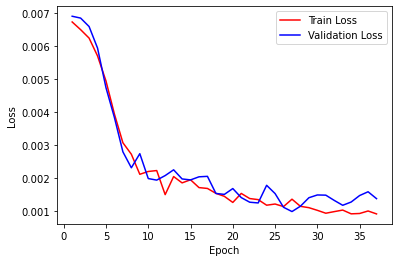

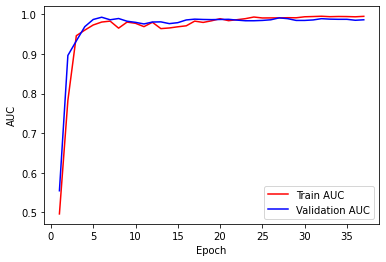

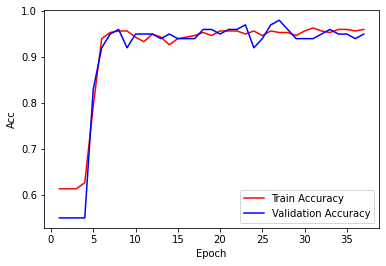

AUC:  0.9918032786885246
MCC:  0.9792938238560596


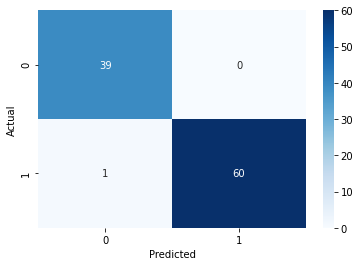

AUC: 0.992
1


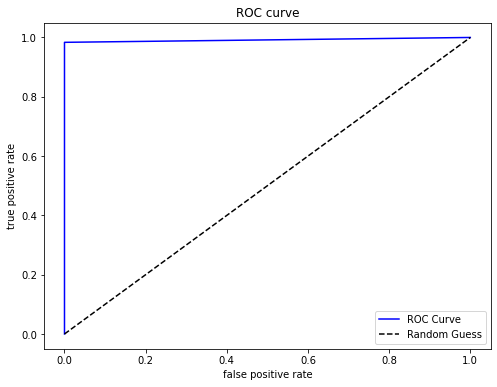

AUC:  0.9918032786885246
MCC:  0.9792938238560596
ACC:  0.99


In [17]:
#-------- Performance --------#

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
plt.show()


#-------- Save results --------#

results_dir = '../results'

try:
    os.mkdir(results_dir)
except:
    pass

plots_dir = '../results/plots'

try:
    os.mkdir(plots_dir)
except:
    pass

results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])

#print(results)
results.to_csv('../results/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energy_{}_separated_{}.csv'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy, str(esm_1b_separated)), index=False)


#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# Plot roc curve

fpr, tpr, thres = roc_curve(results['target'], results['pred'])
print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

plt.figure(figsize=(8,6))

# roc curve
plt.plot(fpr, tpr, "b", label='ROC Curve')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

plt.savefig('../results/plots/targets_vs_preds_emb_{}_HN_{}_nFilt_{}_do_{}_energy_{}_separated_{}_ROC.png'.format(embedding,numHN,numFilter,int(dropOutRate*10), keep_energy, str(esm_1b_separated)))
plt.show()

AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
ACC = accuracy_score(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)
print("ACC: ", ACC)

In [20]:
#storing values
import mlflow
import mlflow.sklearn

experiment_id = mlflow.set_experiment(name_experiment)
experiment = mlflow.get_experiment(experiment_id)

print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    
    mlflow.log_param('esm_1b_separated', str(esm_1b_separated)) ### update
    
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_param('learning rate', learning_rate)
    mlflow.log_param('Weight decay', weight_decay)
    
    mlflow.log_metric('test AUC', AUC)
    mlflow.log_metric('test MCC', MCC)
    mlflow.log_metric('test ACC', ACC)
    
    mlflow.log_metric('train ACC', train_acc[-1])
    mlflow.log_metric('train AUC', train_auc[-1])
    mlflow.log_metric('valid ACC', valid_acc[-1])
    mlflow.log_metric('valid AUC', valid_auc[-1])


Name: Default
Experiment_id: 0
Artifact Location: file:///Users/gulsudedemircan/Documents/github/02456_TCR-pMHC/scripts/mlruns/0
